In [0]:
## Standard imports
import numpy as np
import matplotlib.pyplot as plt
import skimage.io, scipy.ndimage, scipy.interpolate, scipy.signal, scipy.io.wavfile
import skimage.morphology, skimage.transform, skimage.feature, scipy.stats

%matplotlib inline
import matplotlib as mpl
#standard utilities
def show_image(img, title="untitled", cmap="gray", **kwargs):
    plt.figure()
    plt.imshow(img, cmap=cmap, interpolation="nearest", **kwargs)
    plt.axis("off")
    plt.title(title)
    
def load_and_normalise(fname):
    return skimage.io.imread(fname) / 256.0

In [0]:
# resize images
# read images into arrays

import matplotlib.pyplot as plt
%matplotlib inline

import os
import numpy as np
from skimage.io import imread
from skimage.transform import rescale, resize, downscale_local_mean
from PIL import Image

folder = '/Users/Leonore/Documents/Workspace/l4proj/data/raw'

filenames = [os.path.join(folder, f)for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

image_width = 200
image_height = 200

dataset = np.ndarray(shape=(len(filenames), image_width, image_height), dtype=np.float32)

i = 0
for file in filenames:
    try:
        image = imread(file)
        image_resized = resize(image, (image_width, image_height), anti_aliasing=False)
        dataset[i] = image_resized
    except Exception as e:
        print(e)
        print("{} is causing issues".format(file))
    i += 1

Could not find a format to read the specified file in mode 'i'
/Users/Leonore/Documents/Workspace/l4proj/data/raw/.DS_Store is causing issues


In [0]:
from sklearn.model_selection import train_test_split

# splitting and discarding labels as we don't need them
x_train, x_test, _, _ = train_test_split(dataset, dataset, test_size=0.2, random_state=11)

In [0]:
x_train = np.reshape(x_train, (len(x_train), image_width, image_height, 1))
x_test = np.reshape(x_test, (len(x_test), image_width, image_height, 1))

In [0]:
x_train.shape

(471, 200, 200, 1)

In [0]:
# build autoencoder for dataset

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(image_width, image_height, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (5, 5), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
filter_copy = x
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [0]:
autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 200, 200, 1)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 200, 200, 16)      416       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 100, 100, 8)       1160      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 50, 50, 8)         584       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 25, 25, 8)         0   

In [0]:
encoder = Model(inputs=input_img, outputs=encoded)
encoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 200, 200, 1)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 200, 200, 16)      416       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 100, 100, 8)       1160      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 50, 50, 8)         584       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 25, 25, 8)         0   

In [0]:
filter_copy = Model(inputs=input_img, outputs=filter_copy)
filter_copy.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 200, 200, 1)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 200, 200, 16)      416       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 100, 100, 8)       1160      
Total params: 1,576
Trainable params: 1,576
Non-trainable params: 0
_________________________________________________________________


In [0]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [0]:
encoded_imgs = encoder.predict(x_train)

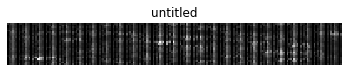

In [0]:
show_image(np.reshape(encoded_imgs[0],(encoder.output.shape[1], encoder.output.shape[2]*encoder.output.shape[3])))

In [0]:
# input = output because this is image reconstruction
autoencoder.fit(x_train, x_train, epochs=50, batch_size=50, shuffle=True, validation_split=0.1)

Train on 423 samples, validate on 48 samples
Epoch 1/50
423/423 [==============================] - 25s 60ms/step - loss: 0.0346 - val_loss: 0.0330
Epoch 2/50
423/423 [==============================] - 22s 51ms/step - loss: 0.0342 - val_loss: 0.0327
Epoch 3/50
423/423 [==============================] - 20s 47ms/step - loss: 0.0339 - val_loss: 0.0324
Epoch 4/50
423/423 [==============================] - 20s 47ms/step - loss: 0.0336 - val_loss: 0.0321
Epoch 5/50
423/423 [==============================] - 20s 46ms/step - loss: 0.0333 - val_loss: 0.0318
Epoch 6/50
423/423 [==============================] - 18s 43ms/step - loss: 0.0330 - val_loss: 0.0315
Epoch 7/50
423/423 [==============================] - 18s 43ms/step - loss: 0.0328 - val_loss: 0.0313
Epoch 8/50
423/423 [==============================] - 18s 43ms/step - loss: 0.0325 - val_loss: 0.0310
Epoch 9/50
423/423 [==============================] - 19s 44ms/step - loss: 0.0322 - val_loss: 0.0307
Epoch 10/50
423/423 [================

KeyboardInterrupt: 

In [0]:
decoded_imgs = autoencoder.predict(x_test)

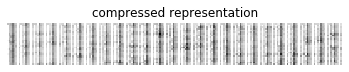

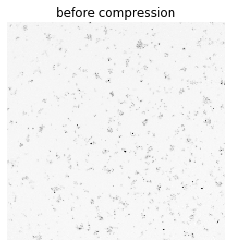

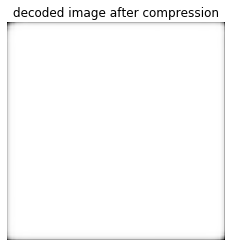

In [0]:
d1 = np.reshape(decoded_imgs[2], (image_width, image_height))
show_image(np.reshape(encoded_imgs[2],(encoder.output.shape[1], encoder.output.shape[2]*encoder.output.shape[3])), "compressed representation", cmap="gist_yarg")
e1 = np.reshape(x_train[2], (image_width, image_height))
show_image(e1, 'before compression', cmap='gist_yarg')
show_image(d1, 'decoded image after compression', cmap='gist_yarg')